# Generación de modelos
En este apartado se generarán los diferentes modelos vistos durante la asignatura para intentar predecir la
categoría del precio de una casa de Airbnb, utilizando el conjunto de datos del preprocesamiento y del
procesado de datos realizado en los apartados anteriores.

## Importación de librerías

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import utilidades
from plot_utilidades import dual_bar_plot

In [2]:
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron

from models_utilities import calculate_metrics, plot_confusion_matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.tree import plot_tree

## Carga de datos

En este apartado se cargarán los 3 conjuntos de datos que se tienen disponibles (Train, test y validación) y
después se realizará una transformación para convertir la columna de precio a una variable
categórica para poder aplicar los algoritmos de clasificación y no de regresión.

In [3]:
df_train = pd.read_csv('../data/generated/tf_train.csv')
df_test = pd.read_csv('../data/generated/tf_test.csv')
df_validacion = pd.read_csv('../data/generated/tf_validation.csv')

In [4]:
dr_price = utilidades.DropColumns(['Unnamed: 0', 'price'])
sl_price = utilidades.SelectColumns(['price'])

In [5]:
X_train = dr_price.fit_transform(df_train)
y_train = sl_price.fit_transform(df_train)

X_test = dr_price.fit_transform(df_test)
y_test = sl_price.fit_transform(df_test)

X_validacion = dr_price.fit_transform(df_validacion)
y_validacion = sl_price.fit_transform(df_validacion)

In [6]:
y_train.describe()

price
count   9509.000000
mean     243.440963
std      382.852834
min       10.000000
25%      112.000000
50%      180.000000
75%      275.000000
max    11400.000000

Se utilizará la información de los cuartiles para generar una versión categórica de la variable price,
utilizando la siguiente escala, basada en los cuartiles y buscando que las muestras queden lo más
equitativas posible, ya que es un factor determinante a la hora de realizar los clasificadores, ya que
si el conjunto está desbalanceado, le puede ser más rentable predecir la clase predominante y posiblemente 
acertar más veces.

* Bajo (0) si el valor es más pequeño que 160€.
* Medio (1) si el valor está comprendido entre 160€ (incluido) y 300€.
* Alto (2) si el valor es mayor o igual a 300€.

Para realizar la transformación se generará una función lambda que se encargue de realizar el proceso.

In [7]:
y_train_c = y_train.copy()
y_train_c['price'] = y_train['price'].apply(lambda x: 0 if x < 160 else 1 if x < 300 else 2)
y_train_c['price'] = y_train_c['price'].astype('category')

In [8]:
y_test_c = y_test.copy()
y_test_c['price'] = y_test_c['price'].apply(lambda x: 0 if x < 160 else 1 if x < 300 else 2)
y_test_c['price'] = y_test_c['price'].astype('category')

In [9]:
y_validacion_c = y_validacion.copy()
y_validacion_c['price'] = y_validacion_c['price'].apply(lambda x: 0 if x < 160 else 1 if x < 300 else 2)
y_validacion_c['price'] = y_validacion_c['price'].astype('category')

En esta tabla y gráfica se aprecia que los datos están bastante balanceados, existe cierta diferencia pero es tolerable.

In [10]:
y_train_c[['price']].groupby(y_train_c['price']).count()

price
price       
0       4026
1       3487
2       1996

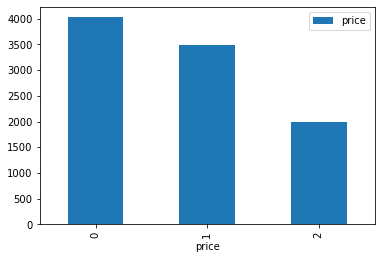

In [11]:
y_train_c[['price']].groupby(y_train_c['price']).count().plot(kind="bar");

Muestra de los datos transformados, en la primera columna se muestra el precio real y en la segunda columna se muestra
la categoría correspondiente.

In [12]:
pd.concat((y_train.head(),y_train_c.head()), axis=1)

price price
0    79.0     0
1   335.0     2
2    40.0     0
3  1161.0     2
4   185.0     1

Al haber realizado una transformación de los datos a categoría, se puede realizar el mismo ```PairPlot``` que se realizó
en el apartado de procesamiento de los datos para visualizar como están distribuidos los datos con las
categorías que se han utilizado.
En este caso, los datos no presentan a priori una buena estructura para conseguir separar las 3 categorías
que se disponen.

In [13]:
df_pairplot = X_train.iloc[:,0:10]
df_pairplot['price'] = y_train_c['price'].astype('category')

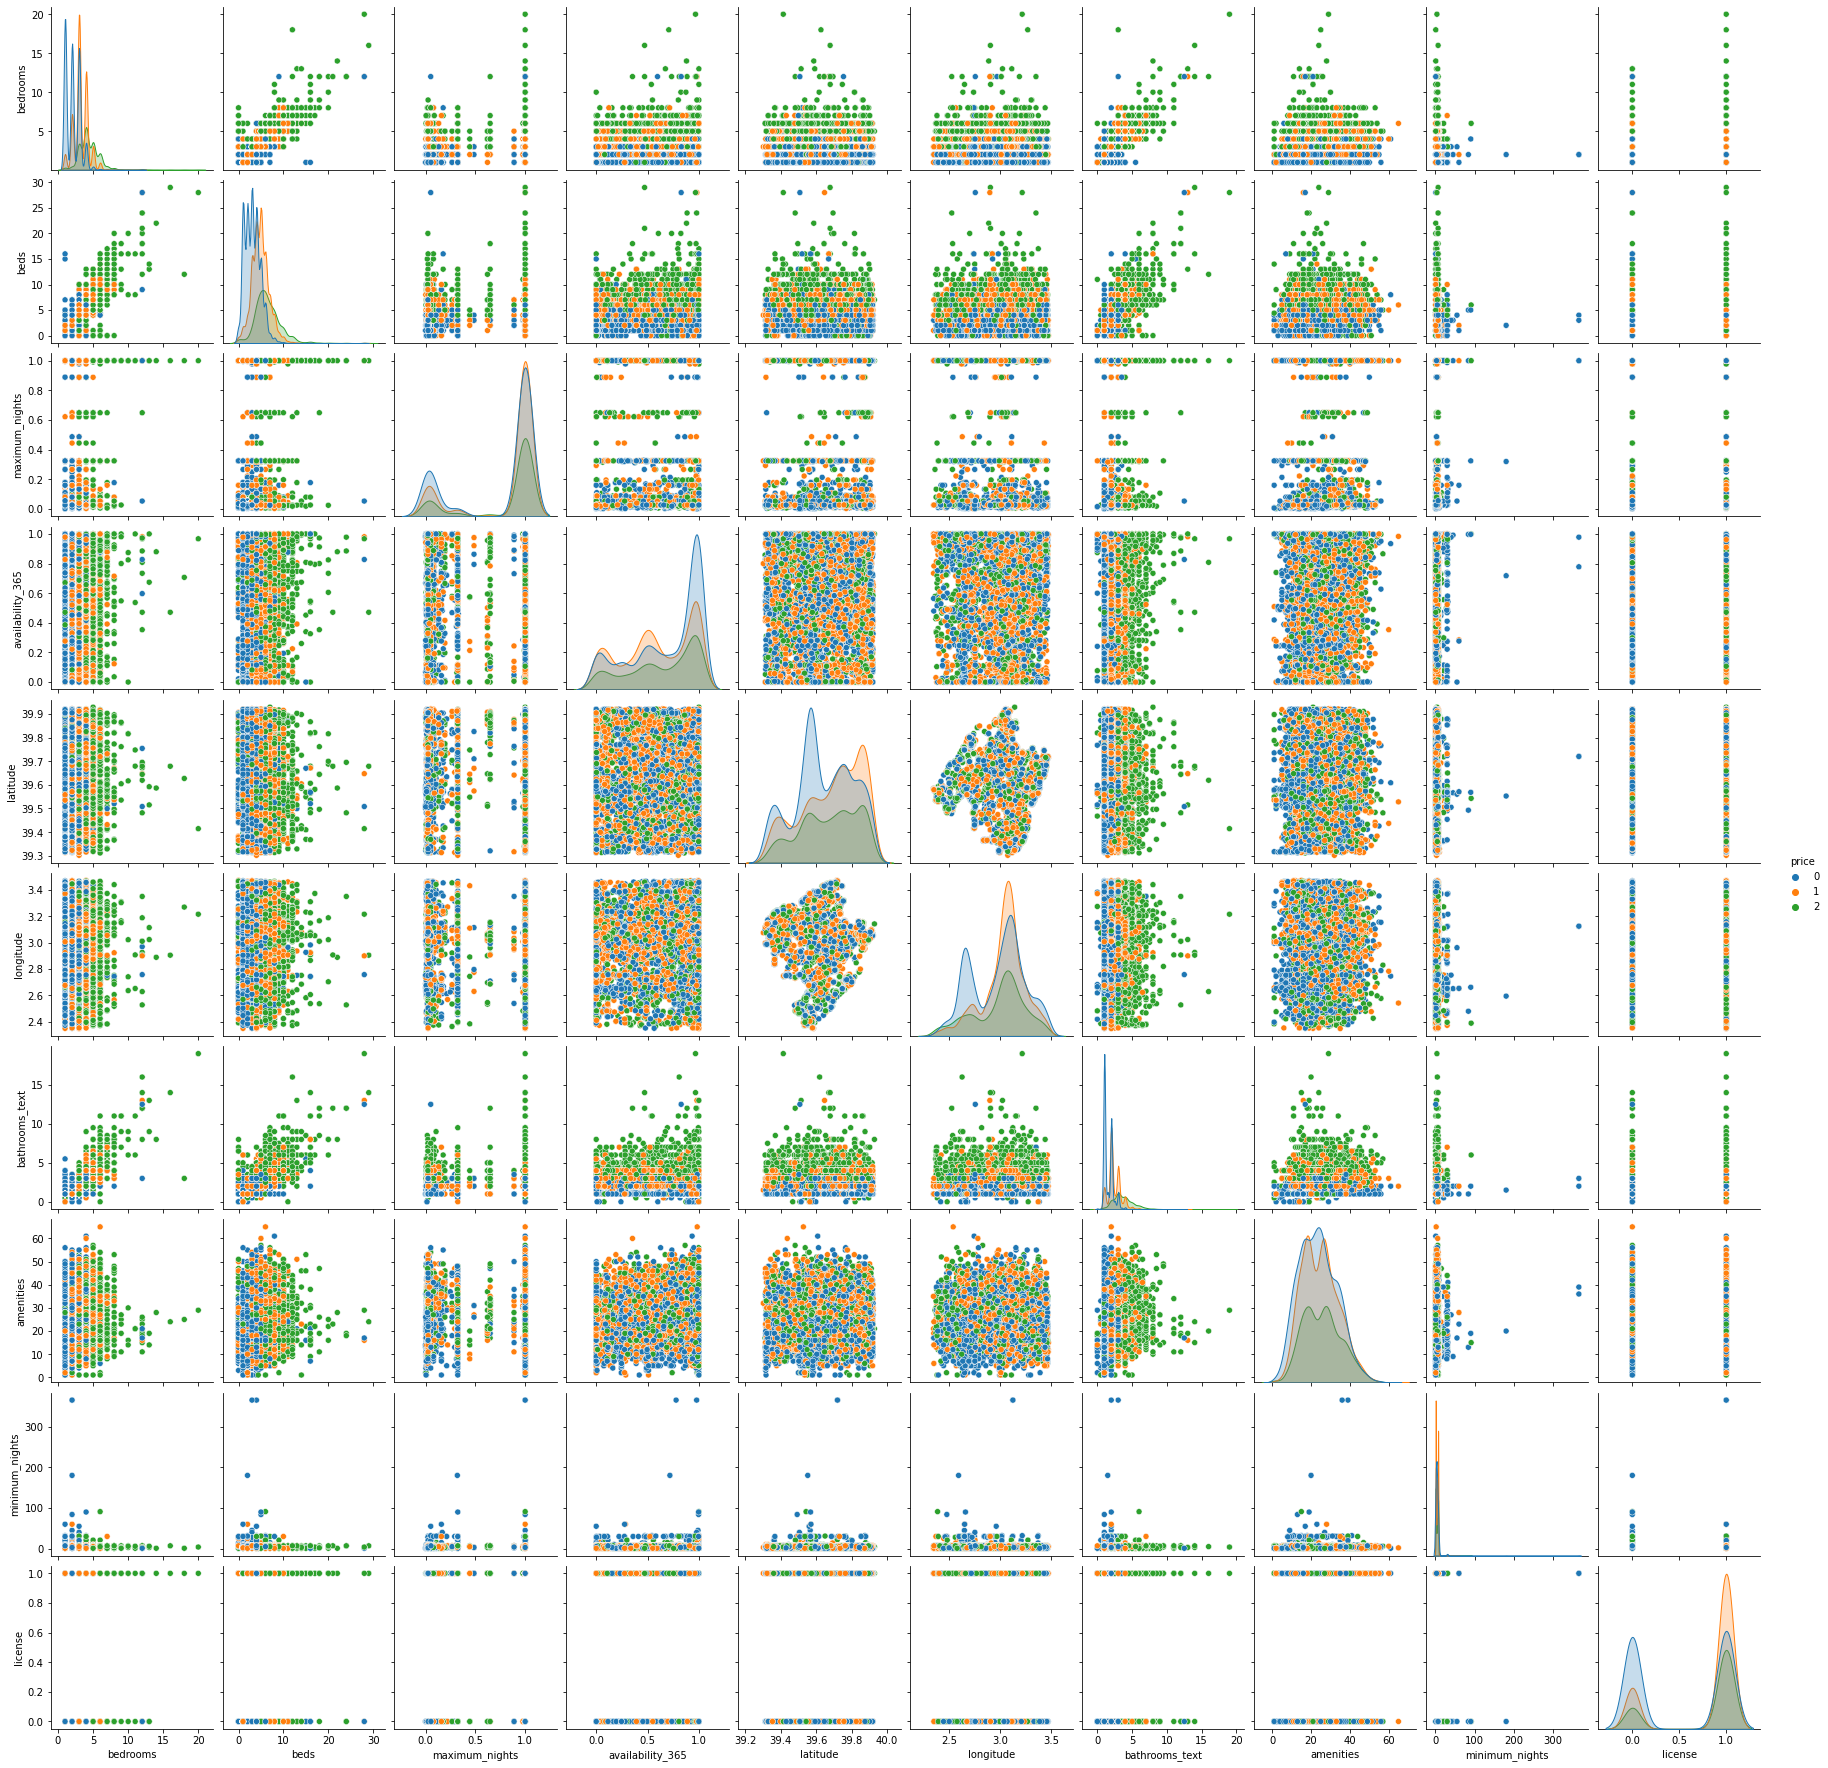

In [14]:
sns.pairplot(df_pairplot, hue='price');

También comentar que los datos que más se alejan en algunas variables suelen ser los apartamentos 
que pertenecen a la clase 2 (precio alto).

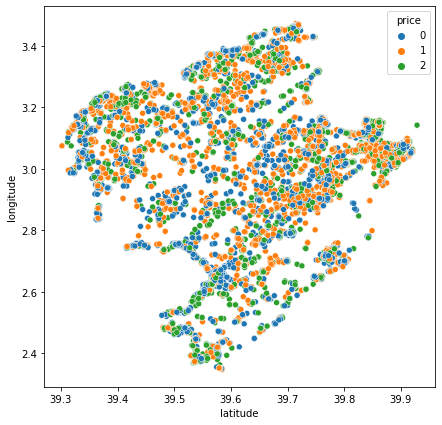

In [15]:
plt.figure(figsize=(7,7))
plt.axis('auto')
sns.scatterplot(x=df_pairplot['latitude'], y=df_pairplot['longitude'], hue=df_pairplot['price'])
plt.show()

Se ha ampliado el gráfico que se ha descubierto mediante el pairplot, que representa la silueta que se parece a la
forma de Mallorca con las categorías de los precios, para visualizarlo con más detalle.
Es curioso observar que casi todas los apartamentos que se encuentran con un alto precio se sitúan en las zonas
turísticas y también cerca del mar.

# PCA

Una vez que se tienen las variables seleccionadas y la variable objetivo transformada a categoría, se procede a
generar el análisis de las componentes principales, para ver si es rentable utilizarlo para predecir los precios.
En este caso se considerará que a partir de un 85% de varianza explicada el PCA es válido para su utilización.
El PCA se calculará con los datos de entrenamiento y se transferirá a los datos de testing y de validación.

In [16]:
pca = PCA()
pca.fit(X_train)

PCA()

In [17]:
pca_cumsum = pca.explained_variance_ratio_.cumsum()

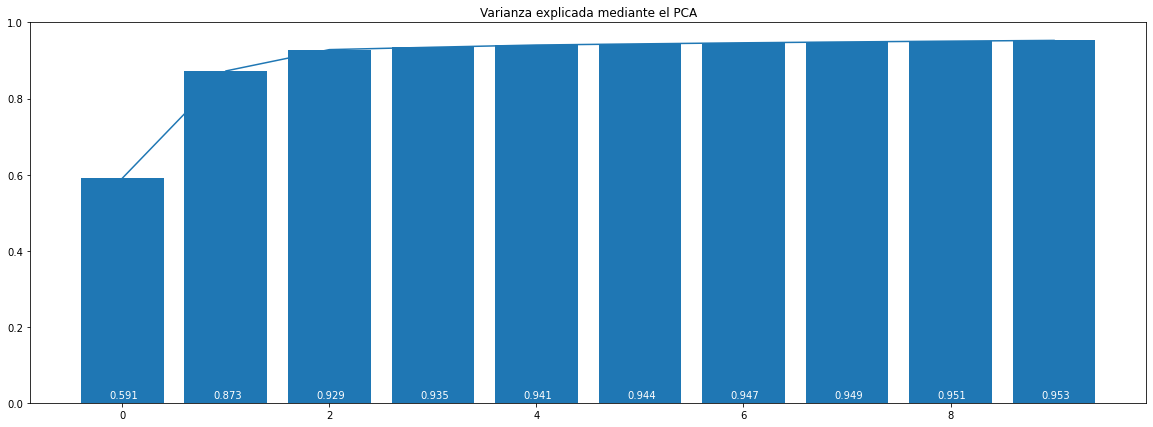

In [18]:
plt.figure(figsize=(20,7))
plt.plot(pca_cumsum[0:10])
plt.bar(np.arange(0, len(pca_cumsum[0:10]), 1.0),pca_cumsum[0:10])
plt.title("Varianza explicada mediante el PCA")
for i, v in enumerate(pca_cumsum[0:10]):
    plt.text(i-0.125, 0.0125, str(round(v,3)), color='white')
plt.show()

En este caso vemos que solamente hacen falta 9 variables para tener explicado el 95% de la varianza de los datos,
superando el objetivo planteado anteriormente que sería un 85%, que se consigue con 2 variables, aunque se utilizarán 9
para tener más explicación de los datos.
Si comparamos que todo el conjunto de datos utiliza 286 variables, poder comprimir todo el conjunto a 9 variables que representen 
casi todo el conjunto de datos es un gran logro, ya que al tener menos variables los modelos supuestamente tardarán menos converger.

In [19]:
len(pca.explained_variance_ratio_)

286

In [20]:
len(X_train.columns)

286

Una vez decidido utilizar 9 componentes principales se transformarán los datos.

In [21]:
X_train_pca = pca.transform(X_train)

In [22]:
X_train_pca = pd.DataFrame(X_train_pca[:, 0:9])

In [23]:
X_test_pca = pd.DataFrame(pca.transform(X_test)[:, 0:9])

In [24]:
X_validacion_pca = pd.DataFrame(pca.transform(X_validacion)[:,0:9])

# Generación de modelos mediante las categorías.

Una vez que se ha realizado todo el proceso de manipulación de datos, se puede considerar que el conjunto está preparado
para los diferentes clasificadores.

En esta implementación se utilizará el conjunto de precios categorizado con las categorías descritas anteriormente.

Para los modelos de clasificación se utilizarán las siguientes métricas:

* Matriz de confusión
* Accuracy
* Precision
* Recall
* F1-score

Para las 4 últimas métricas se generará una función externa al notebook que se encargue de 
calcularlas y, para la matriz de confusión, se realiza una función que permite plotearla.

Como modelo base, se utilizará el ```LogisticRegression``` y después se utilizarán
clasificadores que trabajan con estructuras arbóreas, como los ```DecisionTrees```, los ```RandomForest```,
los ```AdaBoost```, los ```GradientBoostingClassifier``` y el ```Perceptron```.

## Modelo base

Como modelo base, se utilizará el modelo más simple, un clasificador lineal. Con este conjunto de datos es muy posible
que no converja el algoritmo, ya que los datos no presentan una clara separación lineal.

In [25]:
logistic = LogisticRegression(solver='newton-cg', random_state=5)

In [26]:
logistic.fit(X_train, y_train_c['price'])

C:\Users\David\anaconda3\envs\ds-uib\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(random_state=5, solver='newton-cg')

La advertencia que muestra el clasificador es debido a que el algoritmo no consigue converger, se ha probado 
cambiar el ```solver``` y aumentar el número de iteraciones y la advertencia sigue persistiendo,
y esto es un indicador que, muy probablemente, los datos no tengan una separación lineal.

### Métricas de entrenamiento

In [27]:
y_train_c_logistic_predict = logistic.predict(X_train)

In [28]:
cm = confusion_matrix(y_train_c, y_train_c_logistic_predict)

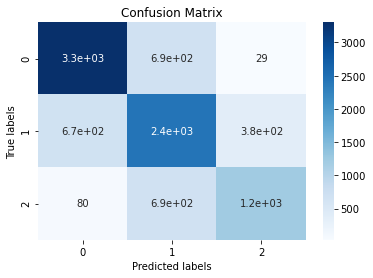

In [29]:
plot_confusion_matrix(cm, labels=[0,1,2])

In [30]:
log_train_r = calculate_metrics(y_train_c, y_train_c_logistic_predict)

Accuracy: 0.732884635608371
Precision: 0.7368171286093351
Recall: 0.732884635608371
F1: 0.7328225628905892


In [31]:
print(classification_report(y_train_c, y_train_c_logistic_predict))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4026
           1       0.64      0.70      0.67      3487
           2       0.75      0.61      0.68      1996

    accuracy                           0.73      9509
   macro avg       0.73      0.71      0.72      9509
weighted avg       0.74      0.73      0.73      9509



### Métricas con el conjunto de test

In [32]:
y_test_c_logistic_predict = logistic.predict(X_test)

In [33]:
cm = confusion_matrix(y_test_c, y_test_c_logistic_predict)

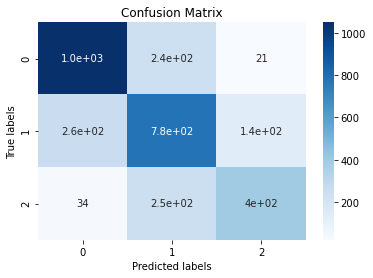

In [34]:
plot_confusion_matrix(cm, labels=[0,1,2])

In [35]:
log_test_r = calculate_metrics(y_test_c, y_test_c_logistic_predict)

Accuracy: 0.7023021128981394
Precision: 0.7040036255307501
Recall: 0.7023021128981394
F1: 0.7015050235704948


In [36]:
print(classification_report(y_test_c, y_test_c_logistic_predict))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1310
           1       0.62      0.66      0.64      1184
           2       0.71      0.58      0.64       677

    accuracy                           0.70      3171
   macro avg       0.70      0.68      0.69      3171
weighted avg       0.70      0.70      0.70      3171



Con este modelo se consigue un 70% de accuracy y un valor de 0.70 de F1-Score, como modelo básico está muy bien y hay
que ver si con modelos más complejos se consigue mejorar este clasificador.

También se aprecia en la matriz de confusión que la segunda categoría se confunde bastante con el resto de categorías.

## Perceptron

El siguiente modelo de clasificación que se utilizará es el **Perceptron**, un tipo de red neuronal simplificada.

In [37]:
perceptron = Perceptron(random_state=5)

In [38]:
perceptron.fit(X_train, y_train_c['price'])

Perceptron(random_state=5)

### Métricas de entrenamiento

In [39]:
y_train_c_perceptron_predict = perceptron.predict(X_train)

In [40]:
cm_perceptron_train = confusion_matrix(y_train_c, y_train_c_perceptron_predict)

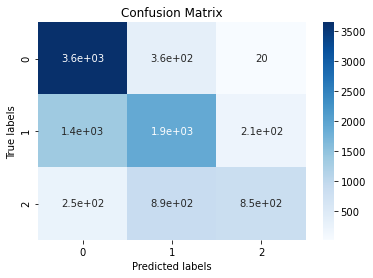

In [41]:
plot_confusion_matrix(cm_perceptron_train, labels=[0,1,2])

In [42]:
perceptron_train_r = calculate_metrics(y_train_c, y_train_c_perceptron_predict)

Accuracy: 0.6734672415606268
Precision: 0.6792839852351091
Recall: 0.6734672415606268
F1: 0.6586419952406248


In [43]:
print(classification_report(y_train_c, y_train_c_perceptron_predict))

              precision    recall  f1-score   support

           0       0.69      0.91      0.78      4026
           1       0.60      0.55      0.57      3487
           2       0.79      0.43      0.55      1996

    accuracy                           0.67      9509
   macro avg       0.69      0.63      0.64      9509
weighted avg       0.68      0.67      0.66      9509



### Métricas con el conjunto de test

In [44]:
y_test_c_perceptron_predict = perceptron.predict(X_test)

In [45]:
cm_perceptron_test = confusion_matrix(y_test_c, y_test_c_perceptron_predict)

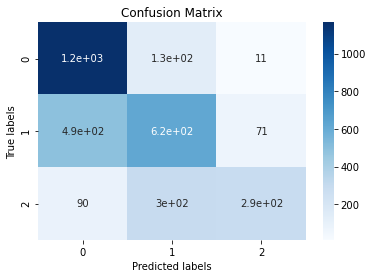

In [46]:
plot_confusion_matrix(cm_perceptron_test, labels=[0,1,2])

In [47]:
perceptron_test_r = calculate_metrics(y_test_c, y_test_c_perceptron_predict)

Accuracy: 0.6546830652790918
Precision: 0.662255620386123
Recall: 0.6546830652790918
F1: 0.6401441373114967


In [48]:
print(classification_report(y_test_c, y_test_c_perceptron_predict))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76      1310
           1       0.59      0.53      0.56      1184
           2       0.78      0.43      0.55       677

    accuracy                           0.65      3171
   macro avg       0.68      0.61      0.62      3171
weighted avg       0.66      0.65      0.64      3171



Con el **Perceptron**, los resultados son peores que si se utiliza el modelo base, aproximadamente un 5% peor, y
confunde bastante más elementos de la clase 1 que el modelo base. Por lo tanto, se descarta este modelo.

## Decision Tree con los parámetros por defecto

El siguiente modelo de clasificación que se utilizará es el **Decision Tree**, el árbol de clasificación más
simple que existe. En este clasificador se utilizarán los parámetros por defecto y no se realizará el proceso de poda,
esto puede producir un alto grado de overfitting, ya que este tipo de árboles no suelen generalizar bien 
los conjuntos de datos.

Se fijará la semilla para que en cada ejecución se tengan los mismos resultados y no dependan del azar.

In [49]:
dt = DecisionTreeClassifier(random_state=5)
dt.fit(X_train, y_train_c.price)

DecisionTreeClassifier(random_state=5)

### Primeros niveles del árbol de decisión

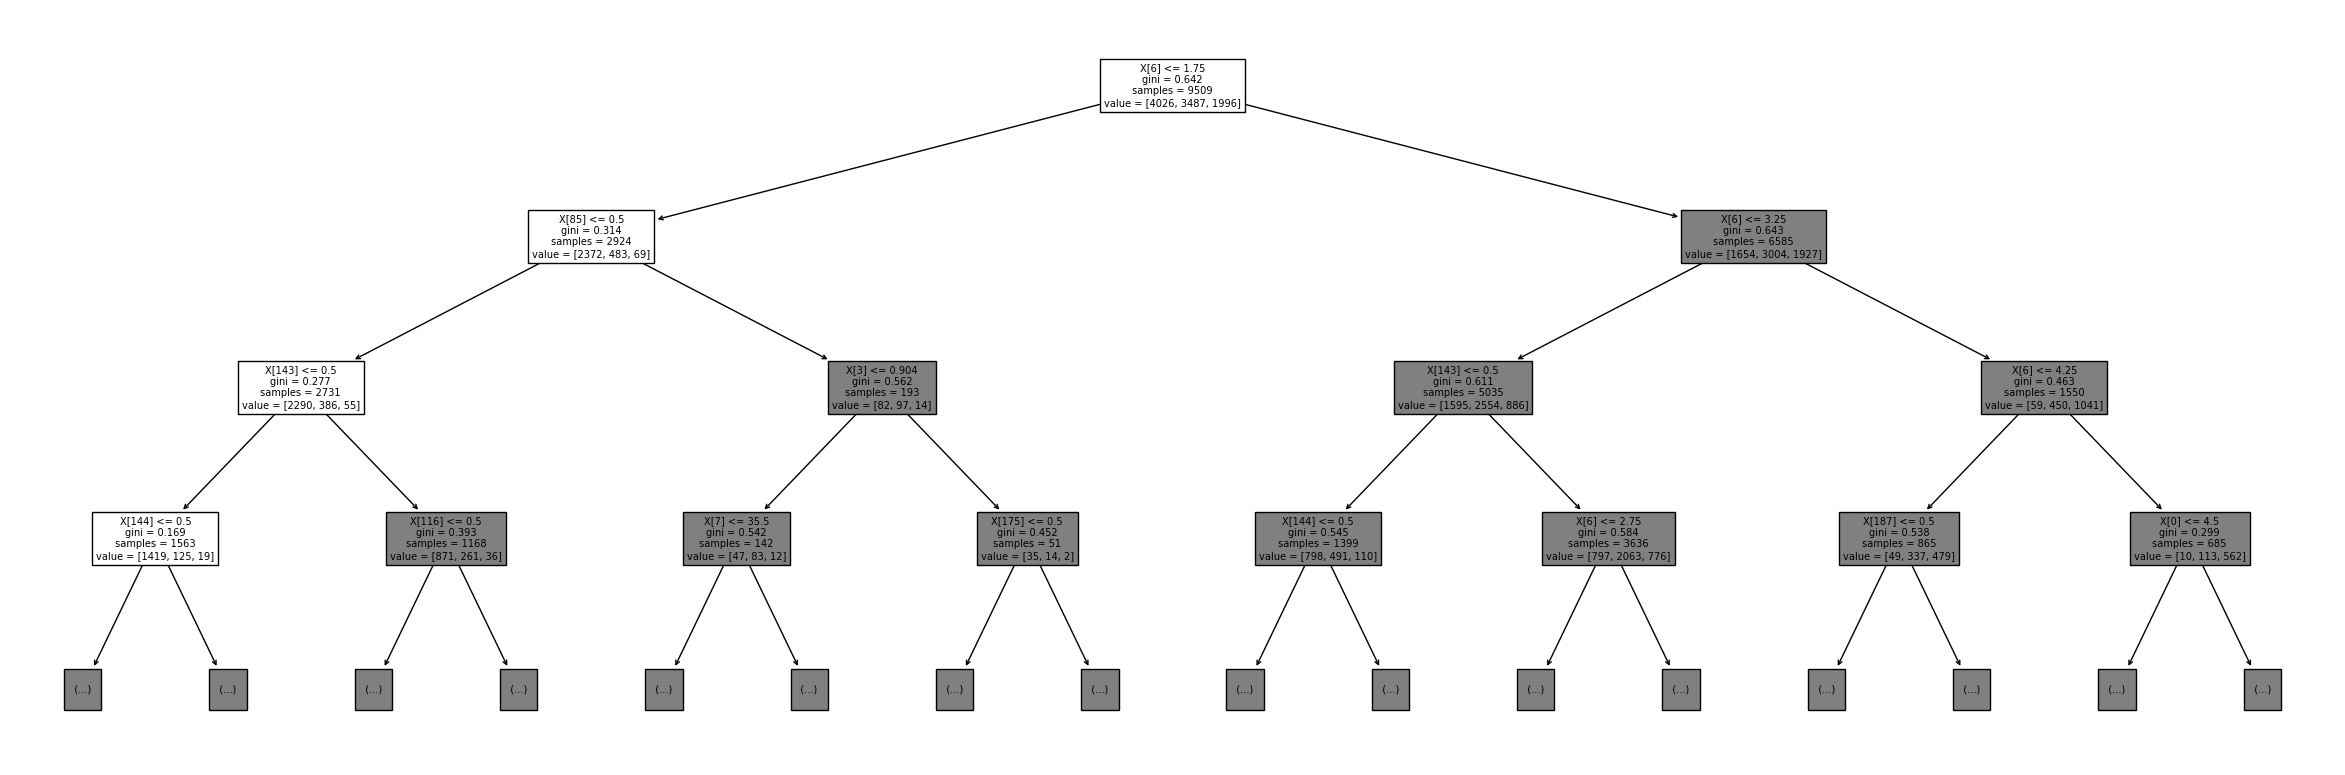

In [50]:
plt.figure(figsize=(30, 10), dpi=100)
plot_tree(dt, max_depth=3)
plt.show()

### Métricas con el conjunto de entrenamiento

In [51]:
y_train_c_dt_predict = dt.predict(X_train)

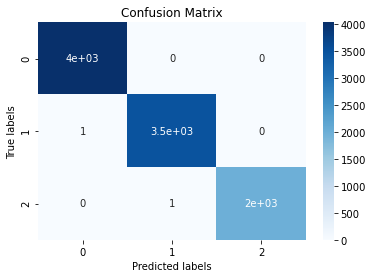

In [52]:
cm_dt_train = confusion_matrix(y_train_c, y_train_c_dt_predict)
plot_confusion_matrix(cm_dt_train, labels=[0,1,2])

In [53]:
dt_train_r = calculate_metrics(y_train_c, y_train_c_dt_predict)

Accuracy: 0.999789672941424
Precision: 0.9997896990560327
Recall: 0.999789672941424
F1: 0.9997896662958017


In [54]:
print(classification_report(y_train_c, y_train_c_dt_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4026
           1       1.00      1.00      1.00      3487
           2       1.00      1.00      1.00      1996

    accuracy                           1.00      9509
   macro avg       1.00      1.00      1.00      9509
weighted avg       1.00      1.00      1.00      9509



### Métricas con el conjunto de test

In [55]:
y_test_c_dt_predict = dt.predict(X_test)

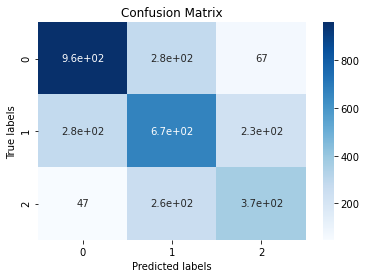

In [56]:
cm_dt_test = confusion_matrix(y_test_c, y_test_c_dt_predict)
plot_confusion_matrix(cm_dt_test, labels=[0,1,2])

In [57]:
dt_test_r = calculate_metrics(y_test_c, y_test_c_dt_predict)

Accuracy: 0.630715862503942
Precision: 0.6318693383885884
Recall: 0.630715862503942
F1: 0.6312392613774256


In [58]:
print(classification_report(y_test_c, y_test_c_dt_predict))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1310
           1       0.55      0.57      0.56      1184
           2       0.55      0.55      0.55       677

    accuracy                           0.63      3171
   macro avg       0.62      0.62      0.62      3171
weighted avg       0.63      0.63      0.63      3171



En este caso se confirma lo comentado al principio, el árbol ha aprendido casi todo el conjunto de entrenamiento,
dando unos valores casi perfectos en las métricas, pero cuando se le propone la tarea de predecir datos que nunca 
ha visto, este valor se reduce bastante siendo peor que el modelo base del que se dispone.
Por lo tanto, este modelo queda descartado

## Decision Tree mediante GridSearch

Visto el resultado del Decision Tree sin poda, se realizará un ```GridSearchCV``` para que intente buscar qué valor es el
más óptimo de profundidad para tener un árbol sin tanto grado de overfitting. En este caso, el ```GridSeachCV``` realizará
una verificación cruzada (K-fold) para poder encontrar la mejor profundidad.
En el GridSearch se utilizará un valor de 5 folds, donde este valor representa que 4/5 (80%) del conjunto de datos se utiliza para
realizar los entrenamientos y un 1/5 (20%) se utiliza para la verificación en cada fold. Los conjuntos se van intercambiando
para realizar todas las posibles permutaciones.

También en el GridSearch se planteará que utilice los 2 criterios qué dispone para determinar que variable aporta más 
información.

In [59]:
params = {'max_depth': range(1, 20), 'criterion':['gini', 'entropy']}

dtc = DecisionTreeClassifier(random_state=5)

gs_clas_DT = GridSearchCV(estimator=dtc,
                         param_grid=params,
                         cv=5,
                         scoring='accuracy', n_jobs=-1, verbose=1)

gs_clas_DT.fit(X_train, y_train_c.price )

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:   14.8s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20)},
             scoring='accuracy', verbose=1)

Con este sistema, se ha podido obtener que la máxima profundidad que debe tener el árbol es de 9 y 
se debe utilizar el criterio gini.

In [60]:
print(gs_clas_DT.best_params_)

{'criterion': 'gini', 'max_depth': 9}


### Primeros niveles del árbol de decisión

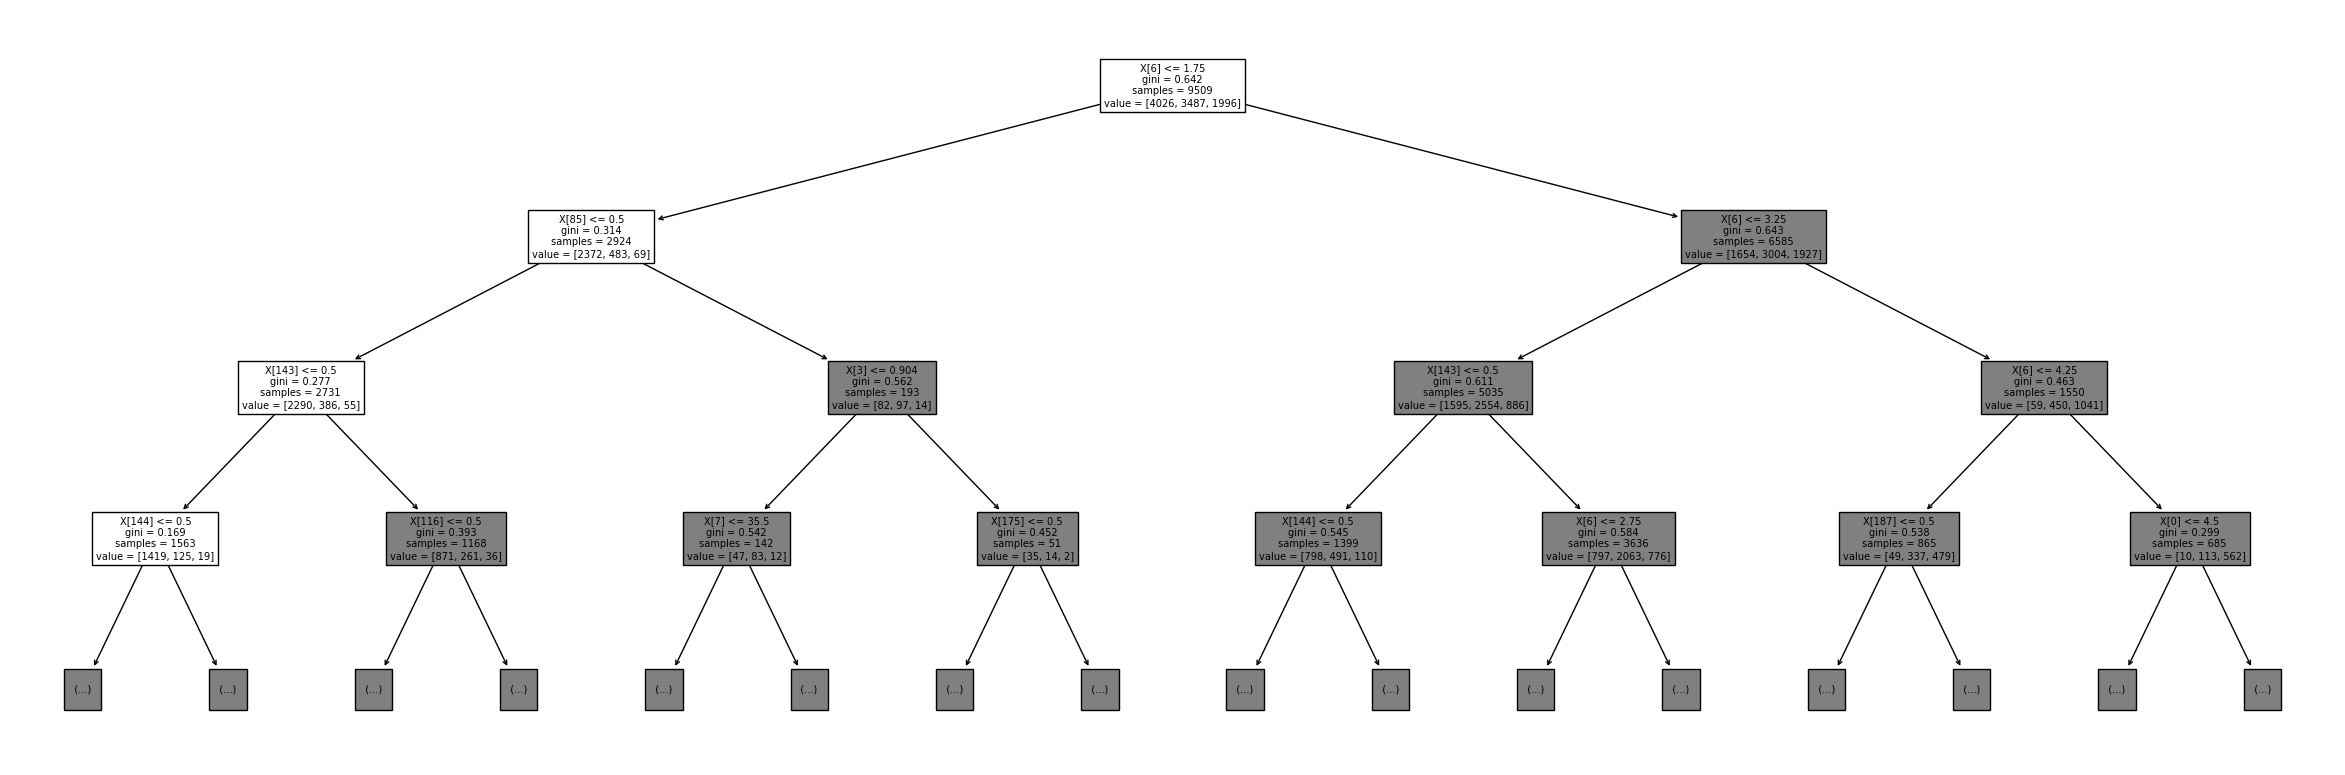

In [61]:
plt.figure(figsize=(30, 10), dpi=100)
plot_tree(gs_clas_DT.best_estimator_, max_depth=3)
plt.show()

### Métricas con el conjunto de entrenamiento

In [62]:
y_train_c_dt_g_predict = gs_clas_DT.predict(X_train)

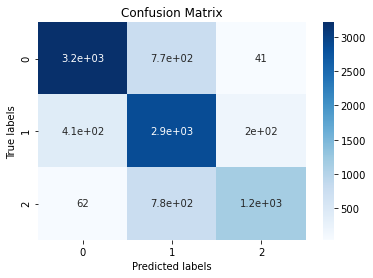

In [63]:
cm_g_dt_train = confusion_matrix(y_train_c, y_train_c_dt_g_predict)
plot_confusion_matrix(cm_g_dt_train, labels=[0,1,2])

In [64]:
dt_g_train_r = calculate_metrics(y_train_c, y_train_c_logistic_predict)

Accuracy: 0.732884635608371
Precision: 0.7368171286093351
Recall: 0.732884635608371
F1: 0.7328225628905892


In [65]:
print(classification_report(y_train_c, y_train_c_logistic_predict))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4026
           1       0.64      0.70      0.67      3487
           2       0.75      0.61      0.68      1996

    accuracy                           0.73      9509
   macro avg       0.73      0.71      0.72      9509
weighted avg       0.74      0.73      0.73      9509



### Métricas con el conjunto de test

In [66]:
y_test_c_dt_g_predict = gs_clas_DT.predict(X_test)

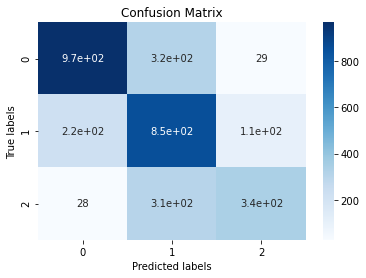

In [67]:
cm_g_dt_test = confusion_matrix(y_test_c, y_test_c_dt_g_predict)
plot_confusion_matrix(cm_g_dt_test, labels=[0,1,2])

In [68]:
dt_g_test_r = calculate_metrics(y_test_c, y_test_c_dt_g_predict)

Accuracy: 0.6811731315042573
Precision: 0.6962092347786503
Recall: 0.6811731315042573
F1: 0.6813164810378785


In [69]:
print(classification_report(y_test_c, y_test_c_dt_g_predict))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1310
           1       0.58      0.72      0.64      1184
           2       0.72      0.50      0.59       677

    accuracy                           0.68      3171
   macro avg       0.70      0.65      0.67      3171
weighted avg       0.70      0.68      0.68      3171



Habiendo realizado la poda, el sistema predice peor el conjunto de entrenamiento, pero generaliza mejor el conjunto de
testeo, pero aún así, sigue siendo peor que el modelo base de predicción.

## Random Forest con los parámetros por defecto

El siguiente modelo que se probará es el Random Forest, que aplica el concepto de Bagging, que consiste en dividir el
conjunto de datos y generar diferentes clasificadores. Con esto se consigue tener diferentes clasificadores y mejorar
el resultado.
En este apartado se utilizará un Random Forest con los parámetros por defecto.

In [70]:
rf = RandomForestClassifier(random_state=5)
rf.fit(X_train, y_train_c.price)

RandomForestClassifier(random_state=5)

### Métricas con el conjunto de entrenamiento

In [71]:
y_train_c_rf_predict = rf.predict(X_train)

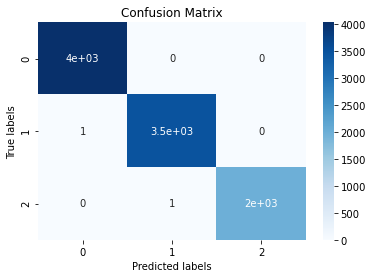

In [72]:
cm_rf_train = confusion_matrix(y_train_c, y_train_c_rf_predict)
plot_confusion_matrix(cm_rf_train, labels=[0,1,2])

In [73]:
rf_train_r = calculate_metrics(y_train_c, y_train_c_rf_predict)

Accuracy: 0.999789672941424
Precision: 0.9997896990560327
Recall: 0.999789672941424
F1: 0.9997896662958017


In [74]:
print(classification_report(y_train_c, y_train_c_rf_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4026
           1       1.00      1.00      1.00      3487
           2       1.00      1.00      1.00      1996

    accuracy                           1.00      9509
   macro avg       1.00      1.00      1.00      9509
weighted avg       1.00      1.00      1.00      9509



### Métricas con el conjunto de test

In [75]:
y_test_c_rf_predict = rf.predict(X_test)

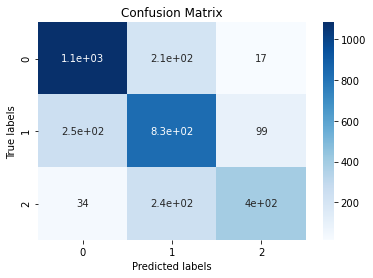

In [76]:
cm_rf_test = confusion_matrix(y_test_c, y_test_c_rf_predict)
plot_confusion_matrix(cm_rf_test, labels=[0,1,2])

In [77]:
rf_test_r = calculate_metrics(y_test_c, y_test_c_rf_predict)

Accuracy: 0.7300536108483129
Precision: 0.7339823341920118
Recall: 0.7300536108483129
F1: 0.7287220439887676


In [78]:
print(classification_report(y_test_c, y_test_c_rf_predict))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1310
           1       0.65      0.70      0.67      1184
           2       0.77      0.59      0.67       677

    accuracy                           0.73      3171
   macro avg       0.74      0.71      0.72      3171
weighted avg       0.73      0.73      0.73      3171



Al ser, al fin y al cabo, una unión de diferentes árboles, el sistema aprende casi a la perfección el conjunto de
entrenamiento pero sufre menos el overfitting que un árbol tradicional, aún así, los resultados obtenidos de las métricas
con el conjunto de test son mejores que el modelo base que se tenía. Por lo tanto, se puede considerar como candidato.

## Random Forest con GridSearch

Una vez comprobado el rendimiento del RandomForest, se va ha realizar una comprobación para ver si, ajustando un poco su
configuración, se consigue mejorar el rendimiento. Para ello se utilizará un GridSearch con los siguientes parámetros:

* Profundidad desde 1 hasta 20.
* Los 2 criterios de selección de clase predominante.
* Nº de árboles del bosque (100, 200, 300).

In [79]:
params = {'max_depth': range(1, 20), 'criterion':['gini', 'entropy'], 'n_estimators':[100,200,300]}

rfc = RandomForestClassifier(random_state=5)

gs_clas_RF = GridSearchCV(estimator=rfc,
                         param_grid=params,
                         cv=5,
                         scoring='accuracy', n_jobs=-1, verbose=1)

gs_clas_RF.fit(X_train, y_train_c.price )

Fitting 5 folds for each of 114 candidates, totalling 570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:  6.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [80]:
gs_clas_RF.best_params_

{'criterion': 'gini', 'max_depth': 18, 'n_estimators': 300}

### Métricas con el conjunto de entrenamiento

In [81]:
y_train_c_rf_g_predict = gs_clas_RF.predict(X_train)

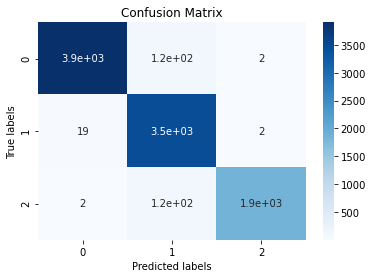

In [82]:
cm_g_rf_train = confusion_matrix(y_train_c, y_train_c_rf_g_predict)
plot_confusion_matrix(cm_g_rf_train, labels=[0,1,2])

In [83]:
g_rf_train_r = calculate_metrics(y_train_c, y_train_c_rf_g_predict)

Accuracy: 0.9722368282679567
Precision: 0.9736330204345625
Recall: 0.9722368282679567
F1: 0.9723555248148975


In [84]:
print(classification_report(y_train_c, y_train_c_rf_g_predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4026
           1       0.94      0.99      0.96      3487
           2       1.00      0.94      0.97      1996

    accuracy                           0.97      9509
   macro avg       0.98      0.97      0.97      9509
weighted avg       0.97      0.97      0.97      9509



### Métricas con el conjunto de test

In [85]:
y_test_c_rf_g_predict = gs_clas_RF.predict(X_test)

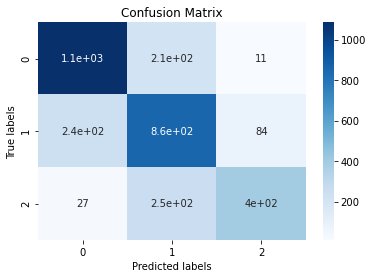

In [86]:
cm_g_rf_test = confusion_matrix(y_test_c, y_test_c_rf_g_predict)
plot_confusion_matrix(cm_g_rf_test, labels=[0,1,2])

In [87]:
g_rf_test_r = calculate_metrics(y_test_c, y_test_c_rf_g_predict)

Accuracy: 0.738883632923368
Precision: 0.7461335693350752
Recall: 0.738883632923368
F1: 0.7378597021019901


In [88]:
print(classification_report(y_test_c, y_test_c_rf_g_predict))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1310
           1       0.65      0.73      0.69      1184
           2       0.81      0.59      0.68       677

    accuracy                           0.74      3171
   macro avg       0.75      0.71      0.73      3171
weighted avg       0.75      0.74      0.74      3171



Al haber ajustado aún más el modelo, se ha conseguido aumentar casi un 1% la tasa de acierto del modelo.
Aún así, queda reflejado que el problema principal reside en clasificar correctamente la segunda clase del
resto de categorías.

## Gradient Boost con los parámetros por defecto

El siguiente clasificador que se probará es el Gradient Boost, un tipo de árbol que intenta combinar varios árboles
sencillos de manera secuencial, donde el árbol hijo intente arreglar los problemas que tiene el su padre.

Este tipo de clasificadores son propensos a tener overfitting.

In [89]:
gbc = GradientBoostingClassifier(random_state=5)
gbc.fit(X_train, y_train_c.price)

GradientBoostingClassifier(random_state=5)

### Métricas con el conjunto de entrenamiento

In [90]:
y_train_c_gbc_predict = gbc.predict(X_train)

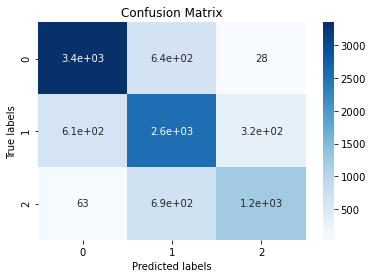

In [91]:
cm_gbc_train = confusion_matrix(y_train_c, y_train_c_gbc_predict)
plot_confusion_matrix(cm_gbc_train, labels=[0,1,2])

In [92]:
gbc_train_r = calculate_metrics(y_train_c, y_train_c_gbc_predict)

Accuracy: 0.7518140708802188
Precision: 0.757183599758286
Recall: 0.7518140708802188
F1: 0.7517836853986211


In [93]:
print(classification_report(y_train_c, y_train_c_gbc_predict))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4026
           1       0.66      0.73      0.69      3487
           2       0.78      0.62      0.69      1996

    accuracy                           0.75      9509
   macro avg       0.76      0.73      0.74      9509
weighted avg       0.76      0.75      0.75      9509



### Métricas con el conjunto de test

In [94]:
y_test_c_gbc_predict = gbc.predict(X_test)

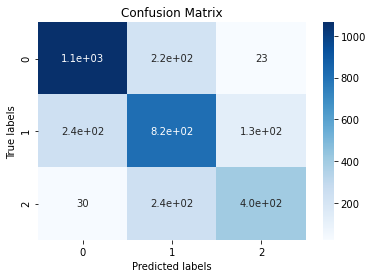

In [95]:
cm_gbc_test = confusion_matrix(y_test_c, y_test_c_gbc_predict)
plot_confusion_matrix(cm_gbc_test, labels=[0,1,2])

In [96]:
gbc_test_r = calculate_metrics(y_test_c, y_test_c_gbc_predict)

Accuracy: 0.7205928729107537
Precision: 0.7227615473468093
Recall: 0.7205928729107537
F1: 0.719913097245166


In [97]:
print(classification_report(y_test_c, y_test_c_gbc_predict))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1310
           1       0.64      0.69      0.66      1184
           2       0.73      0.60      0.66       677

    accuracy                           0.72      3171
   macro avg       0.72      0.70      0.71      3171
weighted avg       0.72      0.72      0.72      3171



Con este sistema se consigue mejorar casi un 2% los resultados del modelo base, pero aun así sigue siendo
peor que el ```RandomForest``` con los parámetros personalizados.

# Gradient Boost con GridSearchCV

Una vez probado con los valores por defecto, se generará un gradient Boost utilizando otros parámetros para ver si el
resultado mejora o empeora.

En este caso se jugará con los siguientes parámetros:

* La profundidad de cada subárbol.
* El número de muestras con las que dividirá.
* El número de muestras mínimas necesarias para tener en un nodo hoja.
* El número máximo de características que se utilizarán.
* El número de boosting stages a realizar.

In [98]:
parameters = {
    "max_depth":[3,5,8],
    "min_samples_split": np.linspace(0.1, 0.5, 3),
    "min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "max_features":["log2","sqrt"],
    "n_estimators":[100, 200]
    }

rfc_g = GradientBoostingClassifier(random_state=5)

gs_clas_GBC = GridSearchCV(estimator=rfc_g,
                         param_grid=parameters,
                         cv=5,
                         scoring='accuracy', n_jobs=-1, verbose=1)

gs_clas_GBC.fit(X_train, y_train_c.price )

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.3min finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': array([0.1, 0.3, 0.5]),
                         'min_samples_split': array([0.1, 0.3, 0.5]),
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [99]:
gs_clas_GBC.best_params_

{'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 200}

### Métricas con el conjunto de entrenamiento

In [100]:
y_train_c_gbc_g_predict = gs_clas_GBC.predict(X_train)

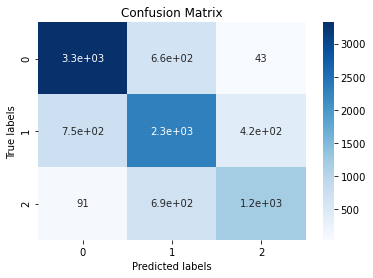

In [101]:
cm_g_gbc_train = confusion_matrix(y_train_c, y_train_c_gbc_g_predict)
plot_confusion_matrix(cm_g_gbc_train, labels=[0,1,2])

In [102]:
g_gbc_train_r = calculate_metrics(y_train_c, y_train_c_gbc_g_predict)

Accuracy: 0.7208959932695341
Precision: 0.7215893842202725
Recall: 0.7208959932695341
F1: 0.7199804670679938


In [103]:
print(classification_report(y_train_c, y_train_c_gbc_g_predict))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4026
           1       0.63      0.66      0.65      3487
           2       0.72      0.61      0.66      1996

    accuracy                           0.72      9509
   macro avg       0.72      0.70      0.71      9509
weighted avg       0.72      0.72      0.72      9509



### Métricas con el conjunto de test

In [104]:
y_test_c_gbc_g_predict = gs_clas_GBC.predict(X_test)

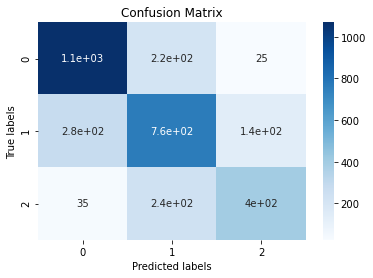

In [105]:
cm_g_gbc_test = confusion_matrix(y_test_c, y_test_c_gbc_g_predict)
plot_confusion_matrix(cm_g_gbc_test, labels=[0,1,2])

In [106]:
g_gbc_test_r = calculate_metrics(y_test_c, y_test_c_gbc_g_predict)

Accuracy: 0.7054556922106591
Precision: 0.7049311294097215
Recall: 0.7054556922106591
F1: 0.7038313163314027


In [107]:
print(classification_report(y_test_c, y_test_c_gbc_g_predict))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1310
           1       0.63      0.65      0.64      1184
           2       0.71      0.60      0.65       677

    accuracy                           0.71      3171
   macro avg       0.70      0.69      0.69      3171
weighted avg       0.70      0.71      0.70      3171



En este caso, habiendo realizado la selección de parámetros, el modelo predice bastante
peor el conjunto de test que si se utiliza el modelo con los parámetros por defecto.
En este caso, se asemeja bastante al modelo base con el que se partía.

## Ada Boost con los parámetros por defecto

Finalmente, el último modelo de clasificación que se probará es el Ada Boost, otro clasificador que hace uso del
concepto de boosting.

In [108]:
abc = AdaBoostClassifier(random_state=5)
abc.fit(X_train, y_train_c.price)

AdaBoostClassifier(random_state=5)

### Métricas con el conjunto de entrenamiento

In [109]:
y_train_c_abc_predict = abc.predict(X_train)

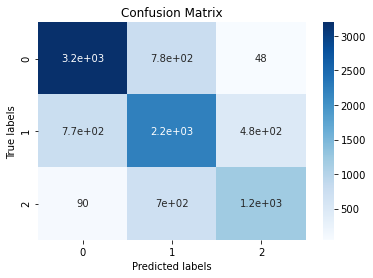

In [110]:
cm_abc_train = confusion_matrix(y_train_c, y_train_c_abc_predict)
plot_confusion_matrix(cm_abc_train, labels=[0,1,2])

In [111]:
abc_train_r = calculate_metrics(y_train_c, y_train_c_abc_predict)

Accuracy: 0.6977600168261647
Precision: 0.6996889181509688
Recall: 0.6977600168261647
F1: 0.6978412981476374


In [112]:
print(classification_report(y_train_c, y_train_c_abc_predict))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4026
           1       0.60      0.64      0.62      3487
           2       0.69      0.60      0.65      1996

    accuracy                           0.70      9509
   macro avg       0.69      0.68      0.69      9509
weighted avg       0.70      0.70      0.70      9509



### Métricas con el conjunto de test

In [113]:
y_test_c_abc_predict = abc.predict(X_test)

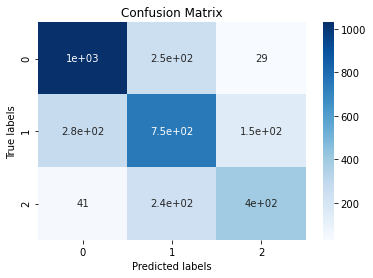

In [114]:
cm_abc_test = confusion_matrix(y_test_c, y_test_c_abc_predict)
plot_confusion_matrix(cm_abc_test, labels=[0,1,2])

In [115]:
abc_test_r = calculate_metrics(y_test_c, y_test_c_abc_predict)

Accuracy: 0.6877956480605487
Precision: 0.6882447344774036
Recall: 0.6877956480605487
F1: 0.6870108221025195


In [116]:
print(classification_report(y_test_c, y_test_c_abc_predict))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1310
           1       0.61      0.64      0.62      1184
           2       0.68      0.59      0.63       677

    accuracy                           0.69      3171
   macro avg       0.69      0.67      0.68      3171
weighted avg       0.69      0.69      0.69      3171



En este caso, los resultados han sido bastante peores que todos los modelos
anteriores que se han probado.

# Verificación

Para obtener cual ha sido el mejor modelo, se realizará un plot con todos los valores de accuracy y F1-Score
obtenidos de los modelos ejecutados con el conjunto de test.

In [117]:
modelos = ['Logistic', 'Perceptron', 'DT', 'DT_C', 'RF', 'RF_c', 'GB', 'GB_C', 'AB']
accuracy_v = [log_test_r[0], perceptron_test_r[0], dt_test_r[0], dt_g_test_r[0], rf_test_r[0], g_rf_test_r[0],
              gbc_test_r[0], g_gbc_test_r[0], abc_test_r[0]]
f1_score_v = [log_test_r[3], perceptron_test_r[3], dt_test_r[3], dt_g_test_r[3], rf_test_r[3], g_rf_test_r[3],
              gbc_test_r[3], g_gbc_test_r[3], abc_test_r[3]]

<Figure size 432x288 with 0 Axes>

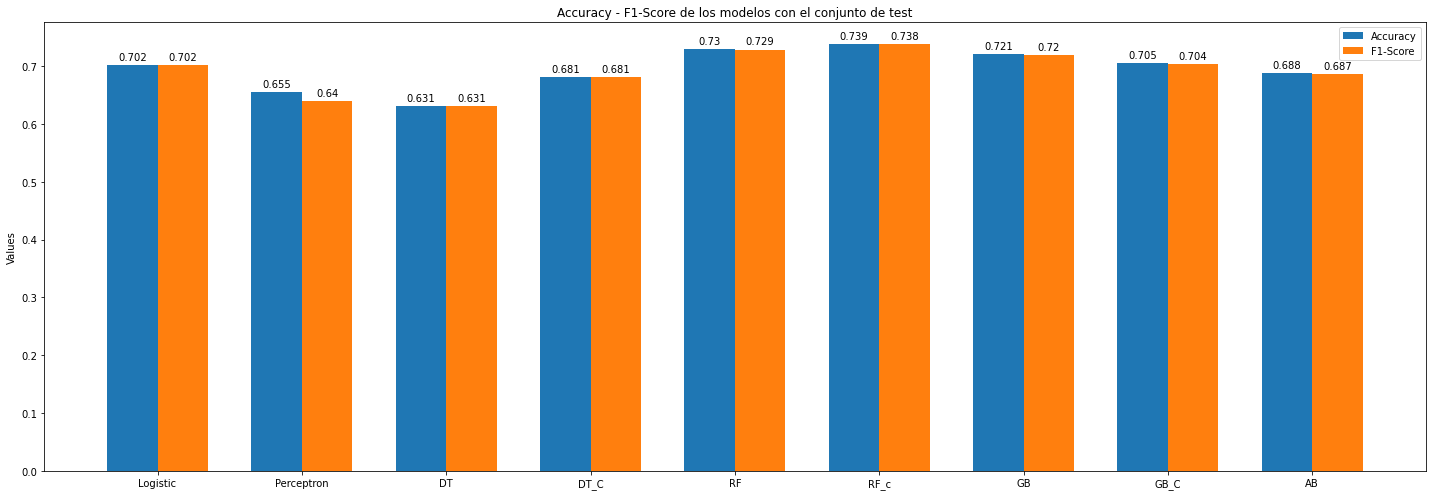

In [118]:
dual_bar_plot(modelos, accuracy_v, f1_score_v, (20,7), 'Values', 'Accuracy', 'F1-Score',
              'Accuracy - F1-Score de los modelos con el conjunto de test')

Una vez que se han entrenado todos los modelos, y se han calculado las métricas con el conjunto de test,
que se visualizan en la gráfica anterior, se ha podido extraer que el mejor clasificador ha sido el 
```RandomForest con la búsqueda de parámetros```.
Aunque los valores no son los más espectaculares (fallaría 1 de cada 4 predicciones aproximadamente), 
es el mejor modelo obtenido y se realizará una prueba con un conjunto de datos totalmente externo al 
proceso de generación de modelos, el conjunto de validación y se verá si las métricas se comportan de 
la misma manera que cuando se realizaba el entrenamiento y la selección del modelo.

También se puede extraer del gráfico que los mejores tipos de clasificador (para este problema dado) son los siguientes:
1. Random Forest
2. Gradient Boost
3. Logistic Regression

Estos 3 tipos de clasificadores son los que se utilizarán con los datos transformados mediante el análisis de
componentes principales (PCA),
ya que estos han sido los mejores cuando se trabajaban con el conjunto de datos sin transformar.

Una vez comentados estos detalles, se procede a calcular las métricas con el conjunto de validación
haciendo uso del mejor clasificador.

In [119]:
y_validacion_p = gs_clas_RF.predict(X_validacion)

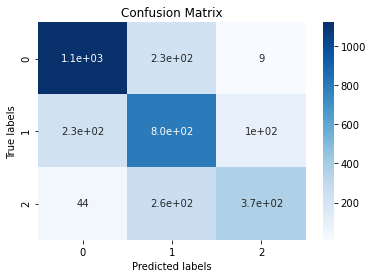

In [120]:
cm_validacion = confusion_matrix(y_validacion_c, y_validacion_p)
plot_confusion_matrix(cm_validacion, labels=[0,1,2])

In [121]:
validacion_r = calculate_metrics(y_validacion_c, y_validacion_p)

Accuracy: 0.7257250945775536
Precision: 0.7322992424382317
Recall: 0.7257250945775536
F1: 0.7241943703200213


In [122]:
print(classification_report(y_validacion_c, y_validacion_p))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1358
           1       0.62      0.71      0.66      1138
           2       0.77      0.55      0.64       676

    accuracy                           0.73      3172
   macro avg       0.73      0.70      0.71      3172
weighted avg       0.73      0.73      0.72      3172



Viendo los resultados del mejor modelo con el conjunto de validación, se puede apreciar que el sistema
se comporta aproximadamente de la misma manera que lo realizaba con el conjunto de test.
Por este motivo, se puede considerar que es un modelo válido.

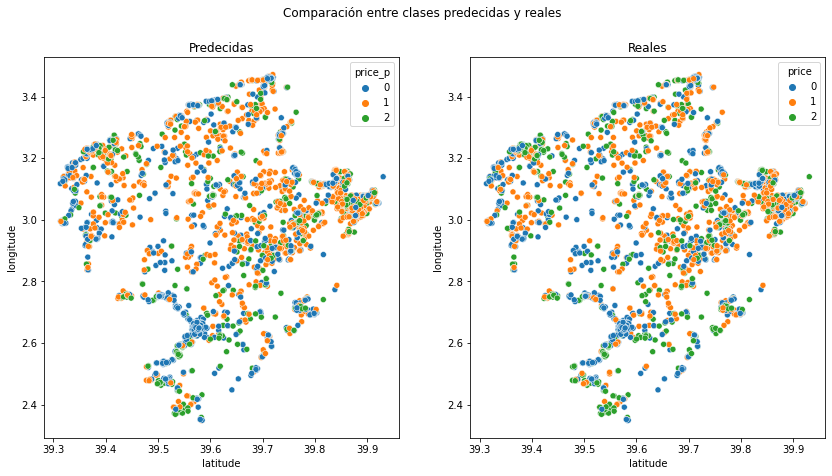

In [123]:
df_pairplot_val = pd.DataFrame({'latitude': X_validacion['latitude'], 'longitude': X_validacion['longitude'], 
                                'price_p':pd.DataFrame(y_validacion_p).iloc[:,0].astype('category'), 
                                'price': y_validacion_c['price']})
plt.figure(figsize=(14,7))
plt.suptitle('Comparación entre clases predecidas y reales')
plt.subplot(1,2,1)
plt.axis('auto')
plt.title('Predecidas')
sns.scatterplot(x=df_pairplot_val['latitude'], y=df_pairplot_val['longitude'], hue=df_pairplot_val['price_p'])
plt.subplot(1,2,2)
plt.axis('auto')
plt.title('Reales')
sns.scatterplot(x=df_pairplot_val['latitude'], y=df_pairplot_val['longitude'], hue=df_pairplot_val['price'])
plt.show()

La gráfica generada confirma lo que nos indica la matriz de confusión, que el sistema confunde bastante la categoría 1 con el resto. También es curioso observar que el problema principalmente surge en la zona central de Mallorca y en la Serra de Tramuntana.

# Modelos con PCA
Una vez que se han ejecutado todos los modelos con el conjunto completo sin aplicar el PCA, se ejecutarán los
mejores tipos de clasificadores que se han obtenido en el apartado anterior y se mirará si al hacer uso del PCA
el sistema consigue predecir mejor el conjunto de datos y si se reduce el tiempo de cálculo.

## Logistic Regression PCA

In [124]:
logistic_pca = LogisticRegression(solver='newton-cg', random_state=5)

In [125]:
logistic_pca.fit(X_train_pca, y_train_c['price'])

LogisticRegression(random_state=5, solver='newton-cg')

### Métricas de entrenamiento

In [126]:
y_train_c_logistic_pca_predict = logistic_pca.predict(X_train_pca)

In [127]:
cm_logistic_pca = confusion_matrix(y_train_c, y_train_c_logistic_pca_predict)

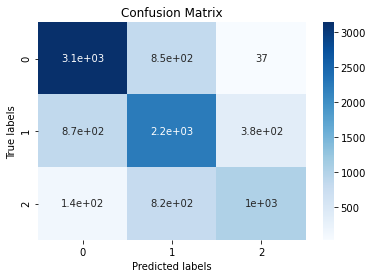

In [128]:
plot_confusion_matrix(cm_logistic_pca, labels=[0,1,2])

In [129]:
log_pca_train_r = calculate_metrics(y_train_c, y_train_c_logistic_pca_predict)

Accuracy: 0.6752550215585235
Precision: 0.6809869305080122
Recall: 0.6752550215585235
F1: 0.6740365639178006


In [130]:
print(classification_report(y_train_c, y_train_c_logistic_pca_predict))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      4026
           1       0.57      0.64      0.61      3487
           2       0.72      0.52      0.60      1996

    accuracy                           0.68      9509
   macro avg       0.68      0.65      0.66      9509
weighted avg       0.68      0.68      0.67      9509



### Métricas con el conjunto de test

In [131]:
y_test_c_logistic_pca_predict = logistic_pca.predict(X_test_pca)

In [132]:
cm_logistic_test_pca = confusion_matrix(y_test_c, y_test_c_logistic_pca_predict)

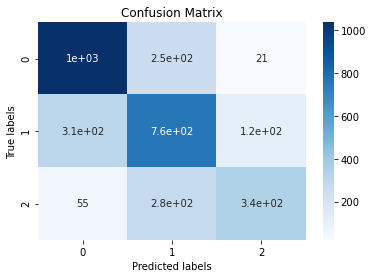

In [133]:
plot_confusion_matrix(cm_logistic_test_pca, labels=[0,1,2])

In [134]:
log_pca_test_r = calculate_metrics(y_test_c, y_test_c_logistic_pca_predict)

Accuracy: 0.674550614947966
Precision: 0.67766899792275
Recall: 0.674550614947966
F1: 0.6717556978538719


In [135]:
print(classification_report(y_test_c, y_test_c_logistic_pca_predict))

              precision    recall  f1-score   support

           0       0.74      0.79      0.77      1310
           1       0.59      0.64      0.61      1184
           2       0.71      0.51      0.59       677

    accuracy                           0.67      3171
   macro avg       0.68      0.65      0.66      3171
weighted avg       0.68      0.67      0.67      3171



En este caso el modelo base se comporta peor que si se utilizara todo el conjunto de datos, 
por ejemplo, la métrica accuracy pierde aproximadamente un 3%.

## Random Forest con los parámetros por defecto PCA

In [136]:
rf_pca = RandomForestClassifier(random_state=5)
rf_pca.fit(X_train_pca, y_train_c.price)

RandomForestClassifier(random_state=5)

### Métricas con el conjunto de entrenamiento

In [137]:
y_train_c_rf_pca_predict = rf_pca.predict(X_train_pca)

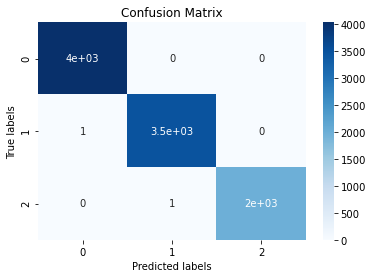

In [138]:
cm_rf_train_pca = confusion_matrix(y_train_c, y_train_c_rf_pca_predict)
plot_confusion_matrix(cm_rf_train_pca, labels=[0,1,2])

In [139]:
rf_train_pca_r = calculate_metrics(y_train_c, y_train_c_rf_pca_predict)

Accuracy: 0.999789672941424
Precision: 0.9997896990560327
Recall: 0.999789672941424
F1: 0.9997896662958017


In [140]:
print(classification_report(y_train_c, y_train_c_rf_pca_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4026
           1       1.00      1.00      1.00      3487
           2       1.00      1.00      1.00      1996

    accuracy                           1.00      9509
   macro avg       1.00      1.00      1.00      9509
weighted avg       1.00      1.00      1.00      9509



### Métricas con el conjunto de test

In [141]:
y_test_c_rf_pca_predict = rf_pca.predict(X_test_pca)

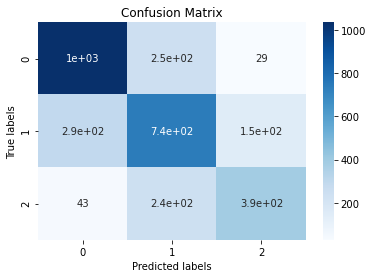

In [142]:
cm_rf_test_pca = confusion_matrix(y_test_c, y_test_c_rf_pca_predict)
plot_confusion_matrix(cm_rf_test_pca, labels=[0,1,2])

In [143]:
rf_test_pca_r = calculate_metrics(y_test_c, y_test_c_rf_pca_predict)

Accuracy: 0.6836959949542731
Precision: 0.683765881320122
Recall: 0.6836959949542731
F1: 0.6824408662583344


In [144]:
print(classification_report(y_test_c, y_test_c_rf_pca_predict))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1310
           1       0.60      0.63      0.61      1184
           2       0.69      0.58      0.63       677

    accuracy                           0.68      3171
   macro avg       0.68      0.66      0.67      3171
weighted avg       0.68      0.68      0.68      3171



Con el Random Forest pasa algo similar, el sistema predice ligeramente peor que su equivalente con todo el
conjunto de datos.

## Random Forest con los mejores parámetros del grid search del apartado sin PCA

In [145]:
rf_pca2 = RandomForestClassifier(random_state=5, criterion='gini', max_depth=18, n_estimators=300)
rf_pca2.fit(X_train_pca, y_train_c.price)

RandomForestClassifier(max_depth=18, n_estimators=300, random_state=5)

### Métricas con el conjunto de entrenamiento

In [146]:
y_train_c_rf_pca_predict2 = rf_pca2.predict(X_train_pca)

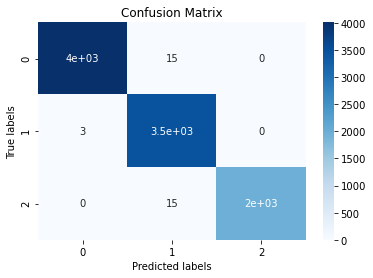

In [147]:
cm_rf_train_pca2 = confusion_matrix(y_train_c, y_train_c_rf_pca_predict2)
plot_confusion_matrix(cm_rf_train_pca2, labels=[0,1,2])

In [148]:
rf_train_pca_r2 = calculate_metrics(y_train_c, y_train_c_rf_pca_predict2)

Accuracy: 0.9965296035334946
Precision: 0.9965529012446506
Recall: 0.9965296035334946
F1: 0.9965319080110184


In [149]:
print(classification_report(y_train_c, y_train_c_rf_pca_predict2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4026
           1       0.99      1.00      1.00      3487
           2       1.00      0.99      1.00      1996

    accuracy                           1.00      9509
   macro avg       1.00      1.00      1.00      9509
weighted avg       1.00      1.00      1.00      9509



### Métricas con el conjunto de test

In [150]:
y_test_c_rf_pca_predict2 = rf_pca2.predict(X_test_pca)

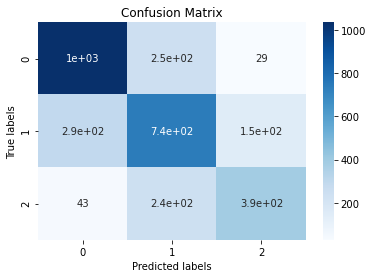

In [151]:
cm_rf_test_pca2 = confusion_matrix(y_test_c, y_test_c_rf_pca_predict2)
plot_confusion_matrix(cm_rf_test_pca, labels=[0,1,2])

In [152]:
rf_test_pca_r2 = calculate_metrics(y_test_c, y_test_c_rf_pca_predict2)

Accuracy: 0.6900031535793125
Precision: 0.6925399081192701
Recall: 0.6900031535793125
F1: 0.6896689745454613


In [153]:
print(classification_report(y_test_c, y_test_c_rf_pca_predict2))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1310
           1       0.60      0.65      0.63      1184
           2       0.70      0.58      0.63       677

    accuracy                           0.69      3171
   macro avg       0.69      0.67      0.68      3171
weighted avg       0.69      0.69      0.69      3171



Es curioso observar que el modelo que mejor funcionaba con todo el conjunto también lo hace con el PCA, 
si solamente se miran los modelos entrenados con el PCA.

## Random Forest con GridSearch

Una vez comprobado el rendimiento del RandomForest y el RandomForest con los parámetros que se han utilizado con todo el
conjunto de entrenamiento, se realizará el mismo GridSearch que se realizó en el apartado anterior.
Para ello se utilizará un GridSearch con los siguientes parámetros:

* Profundidad desde 1 hasta 20.
* Los 2 criterios de selección de clase predominante.
* Nº de árboles del bosque (100, 200, 300).

In [154]:
params = {'max_depth': range(1, 20), 'criterion':['gini', 'entropy'], 'n_estimators':[100,200,300]}

rfc_pca = RandomForestClassifier(random_state=5)

gs_clas_RF_pca = GridSearchCV(estimator=rfc_pca,
                              param_grid=params,
                              cv=5,
                              scoring='accuracy', n_jobs=-1, verbose=1)

gs_clas_RF_pca.fit(X_train_pca, y_train_c.price )

Fitting 5 folds for each of 114 candidates, totalling 570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:  8.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [155]:
gs_clas_RF_pca.best_params_

{'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 300}

### Métricas con el conjunto de entrenamiento

In [156]:
y_train_c_rf_g_pca_predict = gs_clas_RF_pca.predict(X_train_pca)

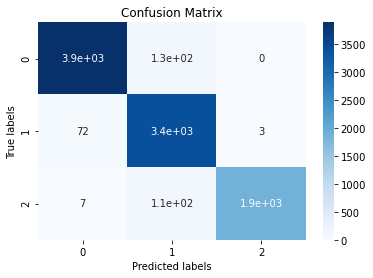

In [157]:
cm_g_rf_pca_train = confusion_matrix(y_train_c, y_train_c_rf_g_pca_predict)
plot_confusion_matrix(cm_g_rf_pca_train, labels=[0,1,2])

In [158]:
g_rf_train_pca_r = calculate_metrics(y_train_c, y_train_c_rf_g_pca_predict)

Accuracy: 0.9660321800399622
Precision: 0.9670502372513985
Recall: 0.9660321800399622
F1: 0.9661655038313964


In [159]:
print(classification_report(y_train_c, y_train_c_rf_g_pca_predict))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4026
           1       0.93      0.98      0.96      3487
           2       1.00      0.94      0.97      1996

    accuracy                           0.97      9509
   macro avg       0.97      0.96      0.97      9509
weighted avg       0.97      0.97      0.97      9509



### Métricas con el conjunto de test

In [160]:
y_test_c_rf_g_pca_predict = gs_clas_RF_pca.predict(X_test_pca)

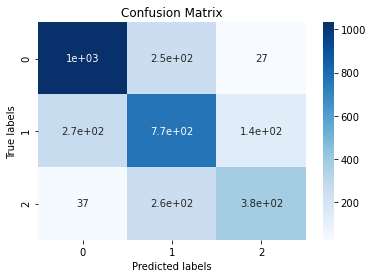

In [161]:
cm_g_rf_pca_test = confusion_matrix(y_test_c, y_test_c_rf_g_pca_predict)
plot_confusion_matrix(cm_g_rf_pca_test, labels=[0,1,2])

In [162]:
g_rf_test_pca_r = calculate_metrics(y_test_c, y_test_c_rf_g_pca_predict)

Accuracy: 0.6890570797855566
Precision: 0.6909069280513349
Recall: 0.6890570797855566
F1: 0.688272315662139


In [163]:
print(classification_report(y_test_c, y_test_c_rf_g_pca_predict))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1310
           1       0.60      0.65      0.62      1184
           2       0.69      0.57      0.63       677

    accuracy                           0.69      3171
   macro avg       0.69      0.67      0.68      3171
weighted avg       0.69      0.69      0.69      3171



En este caso se aprecia que los resultados son ligeramente peores que el modelo anterior
aunque los valores se quedan cercanos.

## Gradient Boost con los parámetros por defecto

In [164]:
gbc_pca = GradientBoostingClassifier(random_state=5)
gbc_pca.fit(X_train_pca, y_train_c.price)

GradientBoostingClassifier(random_state=5)

### Métricas con el conjunto de entrenamiento

In [165]:
y_train_c_gbc_pca_predict = gbc_pca.predict(X_train_pca)

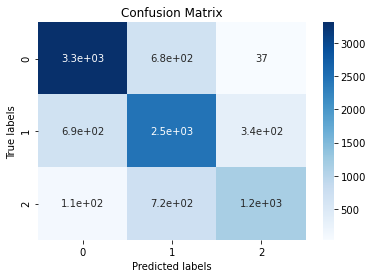

In [166]:
cm_gbc_train_pca = confusion_matrix(y_train_c, y_train_c_gbc_pca_predict)
plot_confusion_matrix(cm_gbc_train_pca, labels=[0,1,2])

In [167]:
gbc_train_pca_r = calculate_metrics(y_train_c, y_train_c_gbc_predict)

Accuracy: 0.7518140708802188
Precision: 0.757183599758286
Recall: 0.7518140708802188
F1: 0.7517836853986211


In [168]:
print(classification_report(y_train_c, y_train_c_gbc_predict))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4026
           1       0.66      0.73      0.69      3487
           2       0.78      0.62      0.69      1996

    accuracy                           0.75      9509
   macro avg       0.76      0.73      0.74      9509
weighted avg       0.76      0.75      0.75      9509



### Métricas con el conjunto de test

In [169]:
y_test_c_gbc_pca_predict = gbc_pca.predict(X_test_pca)

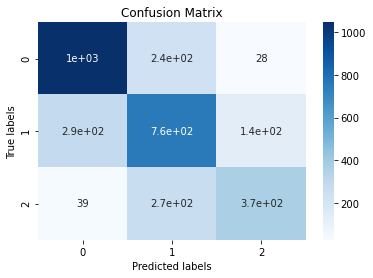

In [170]:
cm_gbc_test_pca = confusion_matrix(y_test_c, y_test_c_gbc_pca_predict)
plot_confusion_matrix(cm_gbc_test_pca, labels=[0,1,2])

In [171]:
gbc_test_pca_r = calculate_metrics(y_test_c, y_test_c_gbc_pca_predict)

Accuracy: 0.6855881425417849
Precision: 0.6864651535953155
Recall: 0.6855881425417849
F1: 0.683761541017422


In [172]:
print(classification_report(y_test_c, y_test_c_gbc_pca_predict))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1310
           1       0.60      0.64      0.62      1184
           2       0.69      0.55      0.61       677

    accuracy                           0.69      3171
   macro avg       0.68      0.66      0.67      3171
weighted avg       0.69      0.69      0.68      3171



En este caso el GradientBoost no consigue superar al RandomForest.

Se realizarán unas gráficas para comparar los modelos equivalentes cuando se utiliza todo el
conjunto de datos y cuando se utiliza el PCA.

In [173]:
modelos_2 = ['Logistic', 'RF', 'RF_c', 'GB']
accuracy_v_all = [log_test_r[0], rf_test_r[0], g_rf_test_r[0], gbc_test_r[0]]
f1_score_v_all = [log_test_r[3], rf_test_r[3], g_rf_test_r[3], gbc_test_r[3]]
accuracy_v_pca = [log_pca_test_r[0], rf_test_pca_r[0], rf_test_pca_r2[0], gbc_test_pca_r[0]]
f1_score_v_pca = [log_pca_test_r[3], rf_test_pca_r[3], rf_test_pca_r2[3], gbc_test_pca_r[3]]

<Figure size 432x288 with 0 Axes>

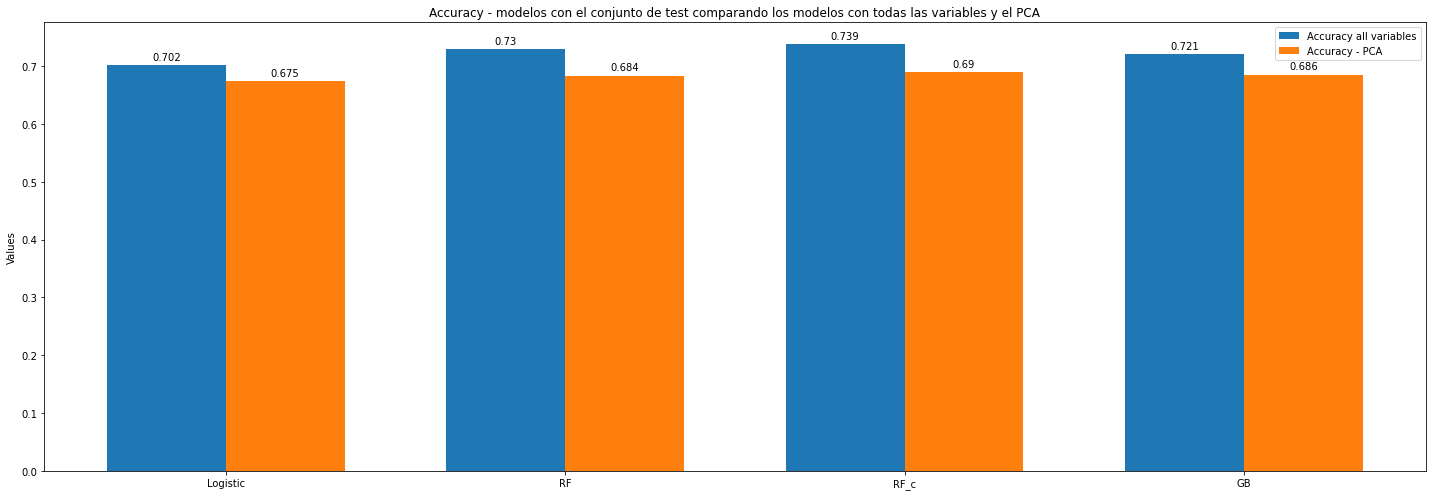

In [174]:
dual_bar_plot(modelos_2, accuracy_v_all, accuracy_v_pca, (20,7), 'Values', 'Accuracy all variables', 
              'Accuracy - PCA', 'Accuracy - modelos con el conjunto de test comparando los modelos con todas las variables y el PCA');

<Figure size 432x288 with 0 Axes>

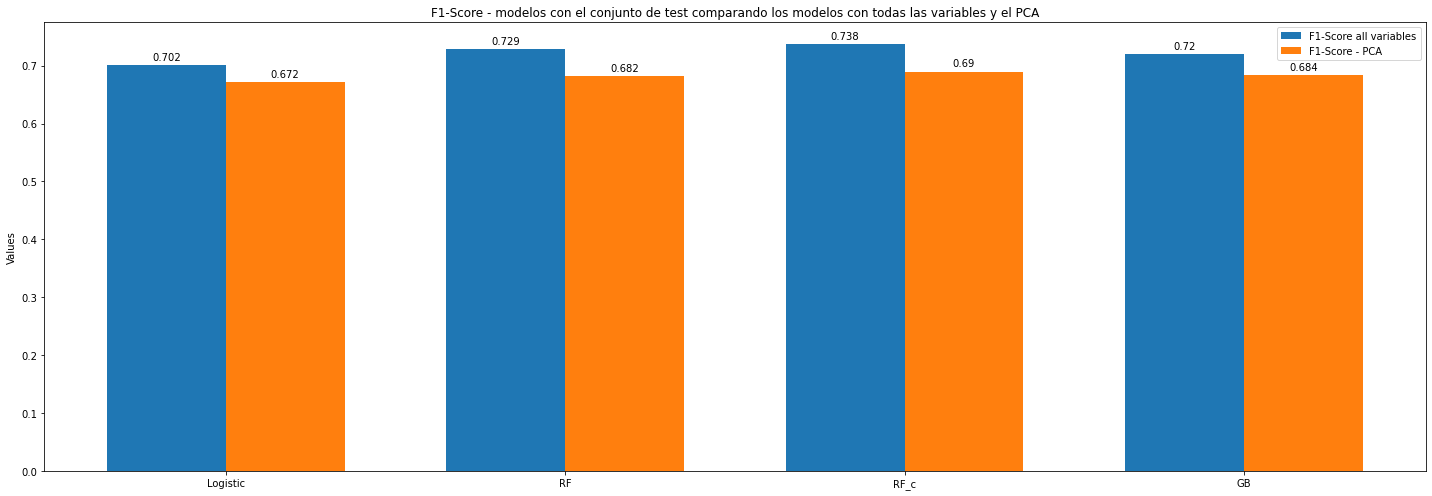

In [175]:
dual_bar_plot(modelos_2, f1_score_v_all, f1_score_v_pca, (20,7), 'Values', 'F1-Score all variables', 
              'F1-Score - PCA', 'F1-Score - modelos con el conjunto de test comparando los modelos con todas las variables y el PCA');

# Conclusiones

Viendo los resultados de la validación, el mejor modelo (```RandomForest con los parámetros modificados y todo el conjunto de datos```)
se comporta con la misma tendencia que tenía con el conjunto de test.
Cuando se hace uso del PCA, los resultados empeoran sus métricas con una variación de un 4-5% y el tiempo de cálculo se ha
visto aumentado, ya que al realizar el GridSearch con el RandomForest, el sistema ha tardado un minuto más 
si se compara con el modelo tradicional en realizar todas las comprobaciones. Por lo tanto, realizar una reducción de 
dimensionalidad, en este caso, funciona ligeramente peor que si se utilizase todo el conjunto de datos.
Generar un clasificador "perfecto" para un conjunto de datos real puede ser una ardua tarea y no siempre se llega
a conseguir, como se ha podido demostrar con este proyecto. 
En este caso, los resultados, aunque no son perfectos, son bastante aceptables, ya que aproximadamente 
fallaría una de cada cuatro predicciones que se realizasen. También, con las matrices de confusión, se aprecia que el 
precio medio se confunde bastante con el resto de categorías, esto se puede interpretar como que un apartamento con
las mismas características teóricas, una persona le ha asignado un precio, mientras que otra le ha asignado otro valor.
Posiblemente si se agregaran nuevas variables de tipo numérico, como los metros cuadrados del apartamento y 
los metros de cada habitación u otros valores, como por ejemplo si se trata de una zona céntrica, turística u otro tipo de zona, 
o si el apartamento es rústico, de nueva construcción o está reformado (parcialmente o total), 
probablemente los modelos pudieran predecir mejor la categoría de los precios. Como Mallorca es una zona turística, 
en general, es posible que los precios fluctúen según la temporada en que nos encontremos y es posible que el conjunto
de datos no refleje esta fluctuación.